In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, precision_recall_curve, auc

rates = 2**np.arange(7)/80
print(rates)

[0.0125 0.025  0.05   0.1    0.2    0.4    0.8   ]


In [2]:
def get_inputs(sm):
    seq_len = 220
    sm = sm.split()
    if len(sm)>218:
        print('SMILES is too long ({:d})'.format(len(sm)))
        sm = sm[:109]+sm[-109:]
    ids = [vocab.stoi.get(token, unk_index) for token in sm]
    ids = [sos_index] + ids + [eos_index]
    seg = [1]*len(ids)
    padding = [pad_index]*(seq_len - len(ids))
    ids.extend(padding), seg.extend(padding)
    return ids, seg

def get_array(smiles):
    x_id, x_seg = [], []
    for sm in smiles:
        a,b = get_inputs(sm)
        x_id.append(a)
        x_seg.append(b)
    return torch.tensor(x_id), torch.tensor(x_seg)

# Smiles Transformer, RNN pre-training model

In [3]:
import torch
from pretrain_trfm import TrfmSeq2seq
from pretrain_rnn import RNNSeq2Seq
# from bert import BERT
from build_vocab import WordVocab
from utils import split

pad_index = 0
unk_index = 1
eos_index = 2
sos_index = 3
mask_index = 4

vocab = WordVocab.load_vocab('pretrained_model/vocab.pkl')

print(len(vocab))
trfm = TrfmSeq2seq(len(vocab), 256, len(vocab), 4)
trfm.load_state_dict(torch.load('pretrained_model/trfm_pretrained.pkl', map_location=torch.device('cpu')))
trfm.eval()
print('Total parameters of Smiles Transformer model:', sum(p.numel() for p in trfm.parameters()))

hidden_size = 256
embed_size = 256


model = RNNSeq2Seq(len(vocab), embed_size, hidden_size, 3)
rnn = RNNSeq2Seq(len(vocab), 256, 256, 3)
rnn.load_state_dict(torch.load('pretrained_model/rnn_pretrained.pkl', map_location=torch.device('cpu')))
rnn.eval()
print('Total parameters of RNN model:', sum(p.numel() for p in rnn.parameters()))

45
Total parameters of Smiles Transformer model: 4245037
Total parameters of RNN model: 4713517


In [4]:
def evaluate_classification(X, y, rate, n_repeats, model='lr'):
    roc_aucs, prc_aucs = np.empty(n_repeats), np.empty(n_repeats)
    for i in range(n_repeats):
        if model=='lr':
            clf = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=5000)
        elif model=='rf':
            clf = RandomForestClassifier(n_estimators=10)
        elif model=='mlp':
            clf = MLPClassifier(max_iter=5000)
        else:
            raise ValueError('Model "{}" is invalid. Specify "ridge" or "rf".'.format(model))
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1-rate, stratify=y)
        clf.fit(X_train, y_train)
        y_score = clf.predict_proba(X_test)
        roc_aucs[i] = roc_auc_score(y_test, y_score[:,1])
        precision, recall, thresholds = precision_recall_curve(y_test, y_score[:,1])
        prc_aucs[i] = auc(recall, precision)
    ret = {}
    ret['roc_auc mean'] = np.mean(roc_aucs)
    ret['roc_auc std'] = np.std(roc_aucs)
    ret['prc_auc mean'] = np.mean(prc_aucs)
    ret['prc_auc std'] = np.std(prc_aucs)
    
    return ret

# BBBP dataset - Blood-brain barrier penetration

In [5]:
df = pd.read_csv('dataset/bbbp.csv')
L = len(df)
print(df.shape)
df.head()
x_split = [split(sm) for sm in df['smiles'].values]
xid, xseg = get_array(x_split)

(2050, 4)
SMILES is too long (256)
SMILES is too long (239)
SMILES is too long (258)
SMILES is too long (380)
SMILES is too long (332)


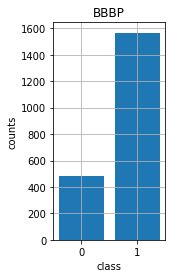

In [6]:
keys = ['0', '1']
bottom = df.groupby('p_np').count()['smiles'].values
plt.figure(figsize=(2,4))
plt.bar(keys, bottom)
plt.xlabel('class')
plt.ylabel('counts')
plt.title('BBBP')
plt.grid()
plt.show()

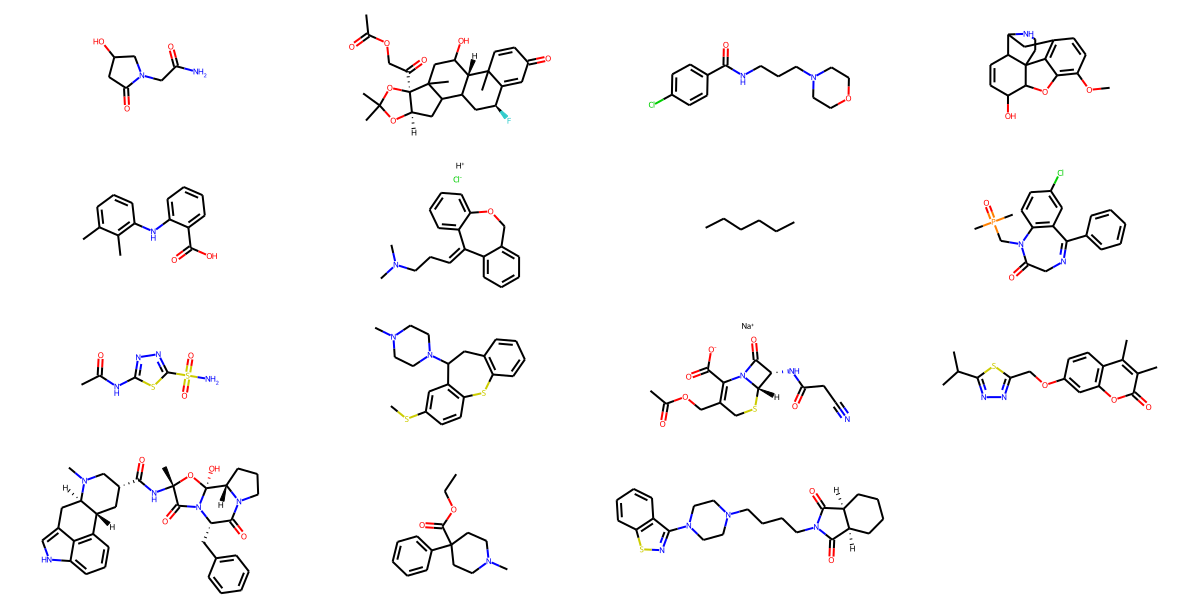

In [7]:
from rdkit.Chem import Draw, MolFromSmiles, MolToSmiles
rands = np.random.choice(L, 16, replace=False)
smiles = df.iloc[rands]['smiles'].values
mols = []
for s in smiles:
    if s is None:
        continue
    mol = MolFromSmiles(s)
    if mol is not None:
        mols.append(mol)
Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(300,150))

# Classification without Pre-training settings

Logistic Regression (LR)

In [8]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(xid, df['p_np'].values, rate, 20, model='lr')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_LR = np.array(scores)
print("Average results: ", np.mean(scores_LR[:, 0]), np.mean(scores_LR[:, 1]))

0.0125 {'roc_auc mean': 0.6066315364655279, 'roc_auc std': 0.07043132771441946, 'prc_auc mean': 0.8029859376708718, 'prc_auc std': 0.039390428240544846}
0.025 {'roc_auc mean': 0.5981320030346484, 'roc_auc std': 0.034137087609430204, 'prc_auc mean': 0.7933406873173626, 'prc_auc std': 0.01932028562506976}
0.05 {'roc_auc mean': 0.5828391135575192, 'roc_auc std': 0.04467432814663686, 'prc_auc mean': 0.7872808847775745, 'prc_auc std': 0.024267715306403814}
0.1 {'roc_auc mean': 0.5839314420803781, 'roc_auc std': 0.0232890100472361, 'prc_auc mean': 0.7826403366118956, 'prc_auc std': 0.01668293140022349}
0.2 {'roc_auc mean': 0.6255246940360794, 'roc_auc std': 0.021610036323657215, 'prc_auc mean': 0.8013631597996469, 'prc_auc std': 0.015323330707306668}
0.4 {'roc_auc mean': 0.6741549889948643, 'roc_auc std': 0.015597752680164315, 'prc_auc mean': 0.8287637422714553, 'prc_auc std': 0.010807909521948256}
0.8 {'roc_auc mean': 0.7091927143374723, 'roc_auc std': 0.019104209219057353, 'prc_auc mean': 

Random Forest Classifier (RF)

In [9]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(xid, df['p_np'].values, rate, 20, model='rf')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_RF = np.array(scores)
print("Average results: ", np.mean(scores_RF[:, 0]), np.mean(scores_RF[:, 1]))

0.0125 {'roc_auc mean': 0.6881543575533995, 'roc_auc std': 0.036636538402345445, 'prc_auc mean': 0.8762689504968296, 'prc_auc std': 0.01927451281379998}
0.025 {'roc_auc mean': 0.7103656376096309, 'roc_auc std': 0.026402147133267655, 'prc_auc mean': 0.8847430409411977, 'prc_auc std': 0.012029779145950627}
0.05 {'roc_auc mean': 0.7423042032274443, 'roc_auc std': 0.026121344670790487, 'prc_auc mean': 0.8998830674917994, 'prc_auc std': 0.010983103801777746}
0.1 {'roc_auc mean': 0.7846285970489932, 'roc_auc std': 0.019978338146706208, 'prc_auc mean': 0.9180543350746853, 'prc_auc std': 0.010246138466569939}
0.2 {'roc_auc mean': 0.8370402793960879, 'roc_auc std': 0.012714198003488506, 'prc_auc mean': 0.9402167914306723, 'prc_auc std': 0.005509434333659809}
0.4 {'roc_auc mean': 0.865414801907557, 'roc_auc std': 0.011535661065375543, 'prc_auc mean': 0.9511000703968577, 'prc_auc std': 0.005493882292734227}
0.8 {'roc_auc mean': 0.8983160963077632, 'roc_auc std': 0.013676939961750359, 'prc_auc mea

Multi-layer Perceptron Classifier (MLP)

In [10]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(xid, df['p_np'].values, rate, 20, model='mlp')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_MLP = np.array(scores)
print("Average results: ", np.mean(scores_MLP[:, 0]), np.mean(scores_MLP[:, 1]))

0.0125 {'roc_auc mean': 0.5919650160618423, 'roc_auc std': 0.06520148441368694, 'prc_auc mean': 0.7935183680814311, 'prc_auc std': 0.036380830468724}
0.025 {'roc_auc mean': 0.5982850902057557, 'roc_auc std': 0.05373151948285195, 'prc_auc mean': 0.790536600865844, 'prc_auc std': 0.03006485113612936}
0.05 {'roc_auc mean': 0.617831783112469, 'roc_auc std': 0.031619060457433894, 'prc_auc mean': 0.8032698126148254, 'prc_auc std': 0.017886323255372216}
0.1 {'roc_auc mean': 0.6555337083231433, 'roc_auc std': 0.03484311122047658, 'prc_auc mean': 0.8222544750309242, 'prc_auc std': 0.02082748384093021}
0.2 {'roc_auc mean': 0.7143785998793499, 'roc_auc std': 0.02221499342362682, 'prc_auc mean': 0.8566058637529743, 'prc_auc std': 0.015625572879950176}
0.4 {'roc_auc mean': 0.7557560528246515, 'roc_auc std': 0.02328151296682525, 'prc_auc mean': 0.8818783695076784, 'prc_auc std': 0.01489800925665952}
0.8 {'roc_auc mean': 0.809770758538915, 'roc_auc std': 0.032575226593833974, 'prc_auc mean': 0.913815

Classification evaluation

c:\users\theanh\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


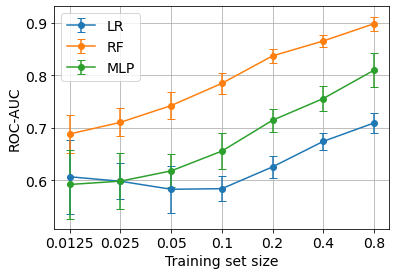

In [11]:
y_LR = np.transpose(scores_LR)[0, :]
err_LR = np.transpose(scores_LR)[1, :]

y_RF = np.transpose(scores_RF)[0, :]
err_RF = np.transpose(scores_RF)[1, :]

y_MLP = np.transpose(scores_MLP)[0, :]
err_MLP = np.transpose(scores_MLP)[1, :]

fig = plt.figure(figsize=(6,9))
plt.rcParams['font.size'] = 14
x=['0.0125','0.025', '0.05',   '0.1',    '0.2',    '0.4',    '0.8']
ax = fig.add_subplot(2, 1, 1)

ax.errorbar(x, y_LR ,yerr=err_LR, fmt='-o', label='LR', capsize=4)
ax.errorbar(x, y_RF ,yerr=err_RF, fmt='-o', label='RF', capsize=4)
ax.errorbar(x, y_MLP ,yerr=err_MLP, fmt='-o', label='MLP', capsize=4)

ax.set_xticks(x)
ax.set_xlabel('Training set size')
ax.set_ylabel('ROC-AUC')
ax.legend()
ax.grid()
fig.show()

# Pre-training SMILES TRANSFORMER model

In [12]:
X_sf = trfm.encode(torch.t(xid))
print(X_sf.shape)

There are 2050 molecules. It will take a little time.
(2050, 1024)


ST + Logistic Regression

In [13]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(X_sf, df['p_np'].values, rate, 20, model='lr')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_sf_LR = np.array(scores)
print("Average results: ", np.mean(scores_sf_LR[:, 0]), np.mean(scores_sf_LR[:, 1]))

0.0125 {'roc_auc mean': 0.8488802079101188, 'roc_auc std': 0.03359842061250339, 'prc_auc mean': 0.9457316074576745, 'prc_auc std': 0.016306945760061167}
0.025 {'roc_auc mean': 0.8704679666744479, 'roc_auc std': 0.02366313544874516, 'prc_auc mean': 0.9530616611980092, 'prc_auc std': 0.012775511177007492}
0.05 {'roc_auc mean': 0.8819458893175953, 'roc_auc std': 0.013162928688150081, 'prc_auc mean': 0.9580173912762044, 'prc_auc std': 0.006426920980048178}
0.1 {'roc_auc mean': 0.9019829624194994, 'roc_auc std': 0.010492069770677105, 'prc_auc mean': 0.9666357675142224, 'prc_auc std': 0.0037186216030528864}
0.2 {'roc_auc mean': 0.9162606085397196, 'roc_auc std': 0.005428715986125175, 'prc_auc mean': 0.971358643489762, 'prc_auc std': 0.0026785489186746613}
0.4 {'roc_auc mean': 0.9274112252384447, 'roc_auc std': 0.00600632342099104, 'prc_auc mean': 0.9752443911997121, 'prc_auc std': 0.0027726849755398647}
0.8 {'roc_auc mean': 0.9393514706366719, 'roc_auc std': 0.01010654437696595, 'prc_auc mea

ST + Random Forest Classifier

In [14]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(X_sf, df['p_np'].values, rate, 20, model='rf')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_sf_RF = np.array(scores)
print("Average results: ", np.mean(scores_sf_RF[:, 0]), np.mean(scores_sf_RF[:, 1]))

0.0125 {'roc_auc mean': 0.8190441511059106, 'roc_auc std': 0.03898209109049727, 'prc_auc mean': 0.9350630349167519, 'prc_auc std': 0.01732103449148412}
0.025 {'roc_auc mean': 0.8466994030746658, 'roc_auc std': 0.01969464729016495, 'prc_auc mean': 0.9464677073292993, 'prc_auc std': 0.008616615443255682}
0.05 {'roc_auc mean': 0.8721618301824124, 'roc_auc std': 0.011242521261122948, 'prc_auc mean': 0.9566147569657788, 'prc_auc std': 0.004611158645315083}
0.1 {'roc_auc mean': 0.888053965924839, 'roc_auc std': 0.008962974682862493, 'prc_auc mean': 0.9621350985145825, 'prc_auc std': 0.003718842390416699}
0.2 {'roc_auc mean': 0.90808506044905, 'roc_auc std': 0.006369802240980911, 'prc_auc mean': 0.9691754317173151, 'prc_auc std': 0.0028044753548052584}
0.4 {'roc_auc mean': 0.9201566397652238, 'roc_auc std': 0.00698170587952732, 'prc_auc mean': 0.9734310199531503, 'prc_auc std': 0.0028228819061156124}
0.8 {'roc_auc mean': 0.9299743091466024, 'roc_auc std': 0.014613116193260474, 'prc_auc mean':

ST + Multi-layer Perceptron Classifier (MLP)

In [15]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(X_sf, df['p_np'].values, rate, 20, model='mlp')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_sf_MLP = np.array(scores)
print("Average results: ", np.mean(scores_sf_MLP[:, 0]), np.mean(scores_sf_MLP[:, 1]))

0.0125 {'roc_auc mean': 0.8482321139334449, 'roc_auc std': 0.045447976613362855, 'prc_auc mean': 0.9442419938006219, 'prc_auc std': 0.02344663513406008}
0.025 {'roc_auc mean': 0.8690934127010592, 'roc_auc std': 0.01839810943910408, 'prc_auc mean': 0.9534023269843527, 'prc_auc std': 0.009214081981818566}
0.05 {'roc_auc mean': 0.8829491799704734, 'roc_auc std': 0.023797486978519505, 'prc_auc mean': 0.9572393756758044, 'prc_auc std': 0.010877190241819544}
0.1 {'roc_auc mean': 0.906929689410614, 'roc_auc std': 0.01173420542814522, 'prc_auc mean': 0.9684415846349097, 'prc_auc std': 0.005877590072133111}
0.2 {'roc_auc mean': 0.9214316776987216, 'roc_auc std': 0.007563427083132911, 'prc_auc mean': 0.9742649351230466, 'prc_auc std': 0.002778257614090337}
0.4 {'roc_auc mean': 0.9336253668378578, 'roc_auc std': 0.005018097813571244, 'prc_auc mean': 0.978352800938274, 'prc_auc std': 0.002235402990224008}
0.8 {'roc_auc mean': 0.9418357432232138, 'roc_auc std': 0.009814439085678466, 'prc_auc mean':

SMILES TRANSFORMER evaluation

c:\users\theanh\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


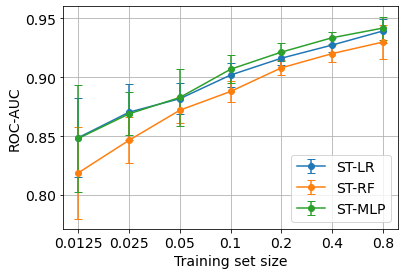

In [16]:
y_sf_LR = np.transpose(scores_sf_LR)[0, :]
err_sf_LR = np.transpose(scores_sf_LR)[1, :]

y_sf_RF = np.transpose(scores_sf_RF)[0, :]
err_sf_RF = np.transpose(scores_sf_RF)[1, :]

y_sf_MLP = np.transpose(scores_sf_MLP)[0, :]
err_sf_MLP = np.transpose(scores_sf_MLP)[1, :]

fig = plt.figure(figsize=(6,9))
plt.rcParams['font.size'] = 14
x=['0.0125','0.025', '0.05',   '0.1',    '0.2',    '0.4',    '0.8']
ax = fig.add_subplot(2, 1, 1)

ax.errorbar(x, y_sf_LR ,yerr=err_sf_LR, fmt='-o', label='ST-LR', capsize=4)
ax.errorbar(x, y_sf_RF ,yerr=err_sf_RF, fmt='-o', label='ST-RF', capsize=4)
ax.errorbar(x, y_sf_MLP ,yerr=err_sf_MLP, fmt='-o', label='ST-MLP', capsize=4)

ax.set_xticks(x)
ax.set_xlabel('Training set size')
ax.set_ylabel('ROC-AUC')
ax.legend()
ax.grid()
plt.savefig('figures/BBBP_st_eval.png', dpi=300)
fig.show()

# Pre-training RNN model

In [17]:
X_rnn = rnn.encode(torch.t(xid))
print(X_rnn.shape)

There are 2050 molecules. It will take a little time.
(2050, 1024)


RNN + Logistic Regression

In [18]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(X_rnn, df['p_np'].values, rate, 20, model='lr')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_rnn_LR = np.array(scores)
print("Average results: ", np.mean(scores_rnn_LR[:, 0]), np.mean(scores_rnn_LR[:, 1]))

0.0125 {'roc_auc mean': 0.7711231507212932, 'roc_auc std': 0.04175898761084096, 'prc_auc mean': 0.8918171940881209, 'prc_auc std': 0.031535274613528654}
0.025 {'roc_auc mean': 0.812504932693056, 'roc_auc std': 0.029975365183738258, 'prc_auc mean': 0.909874282181182, 'prc_auc std': 0.030553579648042097}
0.05 {'roc_auc mean': 0.8511729443661652, 'roc_auc std': 0.021503454036734274, 'prc_auc mean': 0.9398804254928269, 'prc_auc std': 0.020347926812672595}
0.1 {'roc_auc mean': 0.8768952474117551, 'roc_auc std': 0.010894794809558553, 'prc_auc mean': 0.9531026227701023, 'prc_auc std': 0.009681682487734591}
0.2 {'roc_auc mean': 0.9035191015692788, 'roc_auc std': 0.009526604459446171, 'prc_auc mean': 0.9670033652878576, 'prc_auc std': 0.005506878498516012}
0.4 {'roc_auc mean': 0.9283158473954514, 'roc_auc std': 0.007452648691698781, 'prc_auc mean': 0.976185960422406, 'prc_auc std': 0.00477493005242764}
0.8 {'roc_auc mean': 0.9419403181713383, 'roc_auc std': 0.009715797706110809, 'prc_auc mean':

RNN + Random Forest Classifier

In [19]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(X_rnn, df['p_np'].values, rate, 20, model='rf')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_rnn_RF = np.array(scores)
print("Average results: ", np.mean(scores_rnn_RF[:, 0]), np.mean(scores_rnn_RF[:, 1]))

0.0125 {'roc_auc mean': 0.7905060766851392, 'roc_auc std': 0.05108246523518942, 'prc_auc mean': 0.9232687534896942, 'prc_auc std': 0.025142391555142318}
0.025 {'roc_auc mean': 0.8193978849167973, 'roc_auc std': 0.03572269181167784, 'prc_auc mean': 0.937310317426068, 'prc_auc std': 0.014359298275719856}
0.05 {'roc_auc mean': 0.8638988018160776, 'roc_auc std': 0.018307796866068274, 'prc_auc mean': 0.9550136183533491, 'prc_auc std': 0.006929876994696513}
0.1 {'roc_auc mean': 0.8968628841607564, 'roc_auc std': 0.010286079509071103, 'prc_auc mean': 0.9658617307464017, 'prc_auc std': 0.0037804998644415722}
0.2 {'roc_auc mean': 0.915141598697639, 'roc_auc std': 0.006074351023503745, 'prc_auc mean': 0.972604941352048, 'prc_auc std': 0.0021440958887059903}
0.4 {'roc_auc mean': 0.9274436903888482, 'roc_auc std': 0.006203338405208782, 'prc_auc mean': 0.976835196011125, 'prc_auc std': 0.0022555933005969906}
0.8 {'roc_auc mean': 0.9369248377853168, 'roc_auc std': 0.013617031742307382, 'prc_auc mean

RNN + Multi-layer Perceptron Classifier (MLP)

In [20]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(X_rnn, df['p_np'].values, rate, 20, model='mlp')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_rnn_MLP = np.array(scores)
print("Average results: ", np.mean(scores_rnn_MLP[:, 0]), np.mean(scores_rnn_MLP[:, 1]))

0.0125 {'roc_auc mean': 0.7592624418333794, 'roc_auc std': 0.052857823970942276, 'prc_auc mean': 0.8919602441666032, 'prc_auc std': 0.04198860045263358}
0.025 {'roc_auc mean': 0.8101555118329052, 'roc_auc std': 0.03249349686207725, 'prc_auc mean': 0.9249113313191645, 'prc_auc std': 0.023505768334591438}
0.05 {'roc_auc mean': 0.8351881480896216, 'roc_auc std': 0.023790260836109956, 'prc_auc mean': 0.929478535070554, 'prc_auc std': 0.020758739621750493}
0.1 {'roc_auc mean': 0.8568027635118612, 'roc_auc std': 0.010992583678624965, 'prc_auc mean': 0.9571659863402996, 'prc_auc std': 0.0034256414825025758}
0.2 {'roc_auc mean': 0.8884682487542455, 'roc_auc std': 0.00928745138796343, 'prc_auc mean': 0.9649895781775498, 'prc_auc std': 0.004351813965345212}
0.4 {'roc_auc mean': 0.915342901687454, 'roc_auc std': 0.006683914835064996, 'prc_auc mean': 0.9736750572397854, 'prc_auc std': 0.0025332982142499145}
0.8 {'roc_auc mean': 0.9326084450446297, 'roc_auc std': 0.010654292382261843, 'prc_auc mean

# Pre-training RNN Evaluation

c:\users\theanh\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


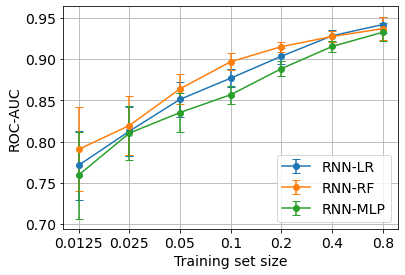

In [21]:
y_rnn_LR = np.transpose(scores_rnn_LR)[0, :]
err_rnn_LR = np.transpose(scores_rnn_LR)[1, :]

y_rnn_RF = np.transpose(scores_rnn_RF)[0, :]
err_rnn_RF = np.transpose(scores_rnn_RF)[1, :]

y_rnn_MLP = np.transpose(scores_rnn_MLP)[0, :]
err_rnn_MLP = np.transpose(scores_rnn_MLP)[1, :]

fig = plt.figure(figsize=(6,9))
plt.rcParams['font.size'] = 14
x=['0.0125','0.025', '0.05',   '0.1',    '0.2',    '0.4',    '0.8']
ax = fig.add_subplot(2, 1, 1)

ax.errorbar(x, y_rnn_LR ,yerr=err_rnn_LR, fmt='-o', label='RNN-LR', capsize=4)
ax.errorbar(x, y_rnn_RF ,yerr=err_rnn_RF, fmt='-o', label='RNN-RF', capsize=4)
ax.errorbar(x, y_rnn_MLP ,yerr=err_rnn_MLP, fmt='-o', label='RNN-MLP', capsize=4)

ax.set_xticks(x)
ax.set_xlabel('Training set size')
ax.set_ylabel('ROC-AUC')
ax.legend()
ax.grid()
fig.show()

# Classification evaluation with Pre-training Smiles Transformer, RNN and without pre-training

c:\users\theanh\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


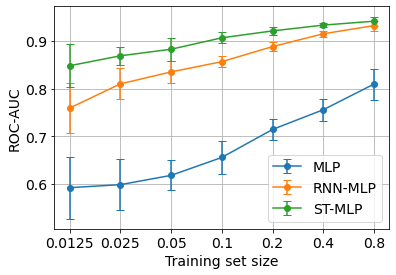

In [22]:
y_MLP = np.transpose(scores_MLP)[0, :]
err_MLP = np.transpose(scores_MLP)[1, :]

y_rnn_MLP = np.transpose(scores_rnn_MLP)[0, :]
err_rnn_MLP = np.transpose(scores_rnn_MLP)[1, :]

y_sf_MLP = np.transpose(scores_sf_MLP)[0, :]
err_sf_MLP = np.transpose(scores_sf_MLP)[1, :]

fig = plt.figure(figsize=(6,9))
plt.rcParams['font.size'] = 14
x=['0.0125','0.025', '0.05',   '0.1',    '0.2',    '0.4',    '0.8']
ax = fig.add_subplot(2, 1, 1)

ax.errorbar(x, y_MLP ,yerr=err_MLP, fmt='-o', label='MLP', capsize=4)
ax.errorbar(x, y_rnn_MLP ,yerr=err_rnn_MLP, fmt='-o', label='RNN-MLP', capsize=4)
ax.errorbar(x, y_sf_MLP ,yerr=err_sf_MLP, fmt='-o', label='ST-MLP', capsize=4)

ax.set_xticks(x)
ax.set_xlabel('Training set size')
ax.set_ylabel('ROC-AUC')
ax.legend()
ax.grid()
plt.savefig('figures/BBBP_pretrain_eval.png', dpi=300)
fig.show()

# Visualization of the Latent Space

In [23]:
from sklearn.manifold import TSNE
X_reduced = TSNE(n_components=2, random_state=0).fit_transform(X_sf)

c:\users\theanh\appdata\local\programs\python\python37\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\users\theanh\appdata\local\programs\python\python37\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [24]:
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(metric='euclidean').fit(X_reduced)
xs = np.linspace(-45, 60, 12)
ys = np.linspace(-40, 10, 12)
ids = []
pts = []
for x,y in zip(xs, ys):
    _, result = nn.kneighbors([[x, y]], n_neighbors=1)
    ids.append(result[0, 0])
    pts.append(X_reduced[result[0, 0]])
pts = np.array(pts)

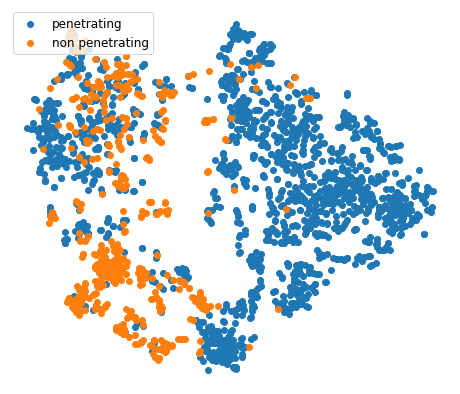

In [26]:
fig = plt.figure(figsize=(8,7))
plt.rcParams['font.size'] = 14
plt.rcParams['font.size'] = 12
plt.scatter(X_reduced[df['p_np']==1][:,0], X_reduced[df['p_np']==1][:,1], label='penetrating', marker='o')
plt.scatter(X_reduced[df['p_np']==0][:,0], X_reduced[df['p_np']==0][:,1], label='non penetrating', marker='o')
plt.axis('off')
# for i in range(12):
#     plt.scatter(pts[i,0], pts[i,1], c='r', marker='${}$'.format(i), s=200*(1+i//10))
plt.legend(loc='upper left')
plt.savefig('figures/bbbp.png', dpi=300)
plt.show()